In [12]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np

import src.data_pipeline # data pipeline

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns


In [8]:
fighters = src.data_pipeline.force_reprocess()

INFO:src.data_pipeline:Cleared cached data - reprocessing...
INFO:src.data_pipeline:Processing UFC fighter data...
INFO:src.data_pipeline:Using raw data: raw
INFO:src.data_pipeline:Using processed data: processed
INFO:src.data_pipeline:Processing raw data...
INFO:src.processing.data_processor:Data loaded successfully. 8250 events, 2598 fighters, 8250 fights.
INFO:src.processing.pre_processor:Standardizing data types and values...
INFO:src.processing.pre_processor:Calculating fight time corrections...
INFO:src.processing.pre_processor:Excluded 146 fights with non-binary outcomes (draws/no contests/etc.)
INFO:src.processing.pre_processor:Performing data validation...
INFO:src.processing.pre_processor:Pre-processing complete. Shape: (8250, 86) -> (8104, 90)
INFO:src.processing.metric_calculator:Adding complementary fight metrics...
INFO:src.processing.data_processor:Preparing fight-level data from preprocessed inputs...
INFO:src.processing.data_processor:✓ Prepared fighter-level data: 162

In [19]:
# Basic data exploration
print("Dataset Shape:", fighters.shape)
print("\nMissing Values:")
missing_pct = (fighters.isnull().sum() / len(fighters) * 100).sort_values(ascending=False)
print(missing_pct[missing_pct > 0].head(10))

print("\nWeight Class Distribution:")
print(fighters['weight_class'].value_counts())

print("\nBasic Stats:")
numeric_cols = fighters.select_dtypes(include=[np.number]).columns
print(f"Numeric columns: {len(numeric_cols)}")
print(f"Average fights per fighter: {fighters['total_UFC_fights'].mean():.1f}")
print(f"Average win rate: {fighters['win_percentage'].mean():.1f}%")

Dataset Shape: (1455, 124)

Missing Values:
nick_name         28.522337
reach_z_score      3.367698
height_z_score     3.367698
dob                0.549828
dtype: float64

Weight Class Distribution:
weight_class
Lightweight             234
Welterweight            228
Middleweight            199
Featherweight           156
Heavyweight             146
Bantamweight            132
Light Heavyweight       122
Flyweight                76
Women's Strawweight      68
Women's Bantamweight     49
Women's Flyweight        45
Name: count, dtype: int64

Basic Stats:
Numeric columns: 115
Average fights per fighter: 9.6
Average win rate: 50.3%


In [20]:
# Define meaningful feature groups - MODIFY THESE based on what you find interesting
feature_categories = {
    'striking_offense': [
        'career_total_sig_str_acc', 'str_landed_per_min', 'kd_per_min', 
        'power_efficiency', 'ko_tko_win_rate',
        'head_str_percentage', 'body_str_percentage', 'leg_str_percentage'
    ],
    
    'striking_defense': [
        'str_efficiency_ratio', 'chin_durability', 'sig_str_absorbed_per_min',
        'times_knockedown_per_min', 'ko_tko_vulnerability'
    ],
    
    'grappling_offense': [
        'career_td_acc', 'td_per_min', 'ctrl_per_min', 
        'submission_threat', 'submission_win_rate', 'submission_conversion_rate'
    ],
    
    'grappling_defense': [
        'career_td_defense', 'takedown_dominance_ratio', 'time_controlled_per_min',
        'submission_vulnerability'
    ],
    
    'style_indicators': [
        'style_diversity_index', 'finish_rate',
        'dist_absorbed_percentage', 'clinch_absorbed_percentage', 'ground_absorbed_percentage'
    ],
    
    'physical': [
        'height_z_score', 'reach_z_score'
    ]
}

# Check which features are available
print("Feature Categories Analysis:")
all_selected = []
for category, features in feature_categories.items():
    available = [f for f in features if f in fighters.columns]
    missing = set(features) - set(available)
    all_selected.extend(available)
    
    print(f"\n{category.upper()}:")
    print(f"  Available: {len(available)}/{len(features)} features")
    if available:
        print(f"  Features: {available}")
    if missing:
        print(f"  Missing: {missing}")

print(f"\nTotal selected features: {len(all_selected)}")


Feature Categories Analysis:

STRIKING_OFFENSE:
  Available: 8/8 features
  Features: ['career_total_sig_str_acc', 'str_landed_per_min', 'kd_per_min', 'power_efficiency', 'ko_tko_win_rate', 'head_str_percentage', 'body_str_percentage', 'leg_str_percentage']

STRIKING_DEFENSE:
  Available: 5/5 features
  Features: ['str_efficiency_ratio', 'chin_durability', 'sig_str_absorbed_per_min', 'times_knockedown_per_min', 'ko_tko_vulnerability']

GRAPPLING_OFFENSE:
  Available: 6/6 features
  Features: ['career_td_acc', 'td_per_min', 'ctrl_per_min', 'submission_threat', 'submission_win_rate', 'submission_conversion_rate']

GRAPPLING_DEFENSE:
  Available: 4/4 features
  Features: ['career_td_defense', 'takedown_dominance_ratio', 'time_controlled_per_min', 'submission_vulnerability']

STYLE_INDICATORS:
  Available: 5/5 features
  Features: ['style_diversity_index', 'finish_rate', 'dist_absorbed_percentage', 'clinch_absorbed_percentage', 'ground_absorbed_percentage']

PHYSICAL:
  Available: 2/2 feat

In [21]:
# Create your feature dataset - START SIMPLE, then add more
core_features = [
    # Basic performance
    'win_percentage', 'finish_rate', 'total_UFC_fights',
    
    # Striking
    'career_total_sig_str_acc', 'str_landed_per_min', 'power_efficiency',
    'ko_tko_win_rate', 'str_efficiency_ratio',
    
    # Grappling  
    'career_td_acc', 'td_per_min', 'submission_win_rate', 'career_td_defense',
    
    # Style
    'style_diversity_index',
    'head_str_percentage', 'body_str_percentage', 'leg_str_percentage',
    
    # Physical
    'height_z_score', 'reach_z_score'
]

# Filter to available features
available_features = [f for f in core_features if f in fighters.columns]
print(f"Using {len(available_features)} core features")

# Create working dataset
work_data = fighters[['id', 'name', 'weight_class'] + available_features].copy()

print(f"\nWorking dataset shape: {work_data.shape}")
print(f"Features: {available_features}")

Using 18 core features

Working dataset shape: (1455, 21)
Features: ['win_percentage', 'finish_rate', 'total_UFC_fights', 'career_total_sig_str_acc', 'str_landed_per_min', 'power_efficiency', 'ko_tko_win_rate', 'str_efficiency_ratio', 'career_td_acc', 'td_per_min', 'submission_win_rate', 'career_td_defense', 'style_diversity_index', 'head_str_percentage', 'body_str_percentage', 'leg_str_percentage', 'height_z_score', 'reach_z_score']


In [22]:
print("Missing Values Analysis:")
missing_info = work_data[available_features].isnull().sum()
missing_pct = (missing_info / len(work_data)) * 100

for feature, pct in missing_pct[missing_pct > 0].items():
    print(f"  {feature}: {missing_info[feature]} ({pct:.1f}%)")

# Strategy 1: Fill with weight class medians
print(f"\nBefore cleaning: {len(work_data)} fighters")

for feature in available_features:
    if work_data[feature].isnull().any():
        # Fill with weight class median, then overall median
        work_data[feature] = work_data.groupby('weight_class')[feature].transform(
            lambda x: x.fillna(x.median())
        )
        work_data[feature] = work_data[feature].fillna(work_data[feature].median())

# Remove extreme outliers (optional - experiment with this)
remove_outliers = True
if remove_outliers:
    for feature in available_features:
        Q1 = work_data[feature].quantile(0.25)
        Q3 = work_data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        work_data = work_data[(work_data[feature] >= lower_bound) & (work_data[feature] <= upper_bound)]

print(f"After cleaning: {len(work_data)} fighters")
print("✅ No missing values:", work_data[available_features].isnull().sum().sum() == 0)

Missing Values Analysis:
  height_z_score: 49 (3.4%)
  reach_z_score: 49 (3.4%)

Before cleaning: 1455 fighters
After cleaning: 1060 fighters
✅ No missing values: True


Feature scaling complete
Scaled data shape: (1060, 18)


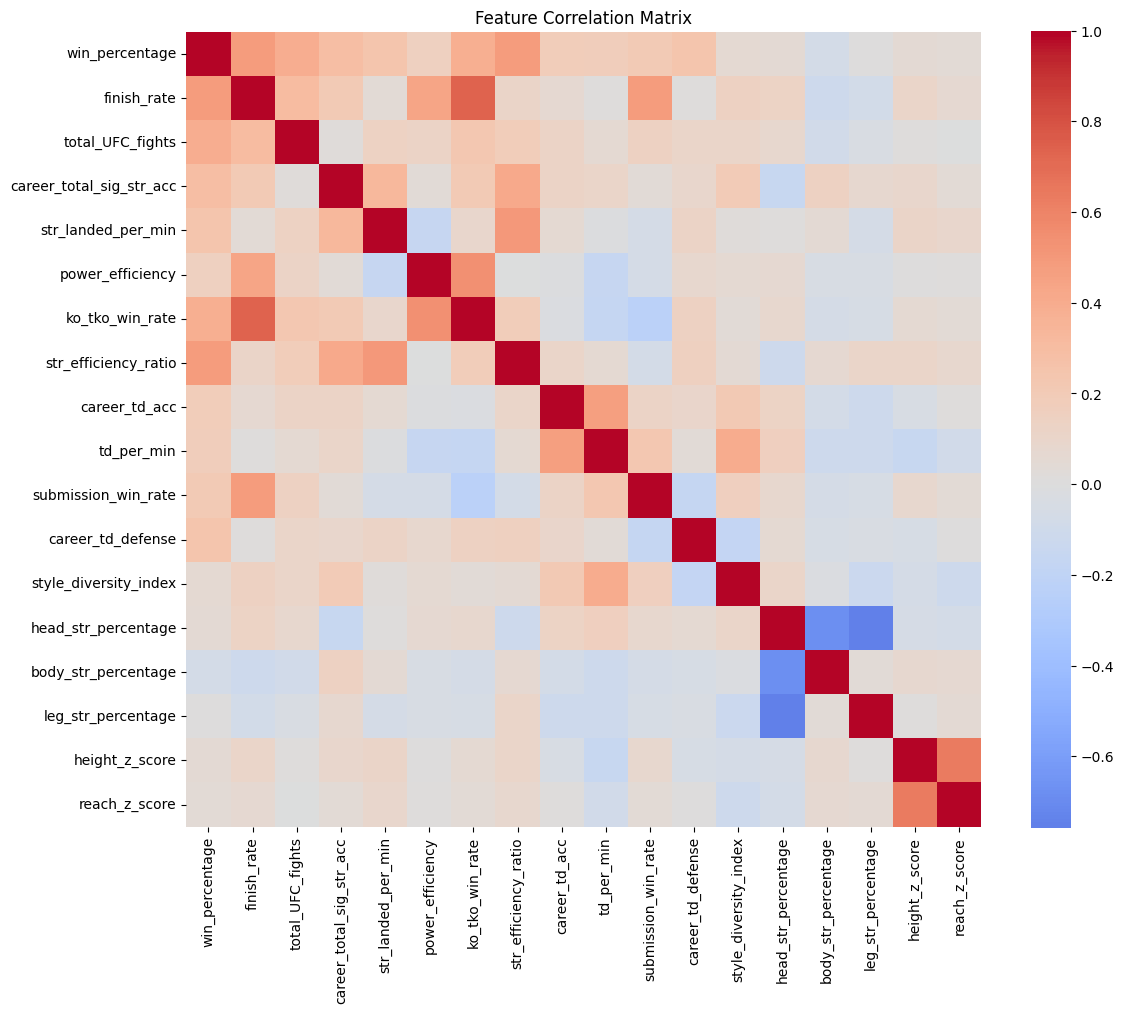


No highly correlated features found (good!)


In [23]:
# Scale features
scaler = RobustScaler()  # Less sensitive to outliers than StandardScaler
scaled_features = scaler.fit_transform(work_data[available_features])
scaled_df = pd.DataFrame(scaled_features, columns=available_features, index=work_data.index)

print("Feature scaling complete")
print(f"Scaled data shape: {scaled_df.shape}")

# Quick correlation heatmap (to spot highly correlated features)
plt.figure(figsize=(12, 10))
corr_matrix = scaled_df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Find highly correlated pairs (>0.8)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                corr_matrix.columns[i], 
                corr_matrix.columns[j], 
                corr_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print("\nHighly correlated features (>0.8):")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")
else:
    print("\nNo highly correlated features found (good!)")

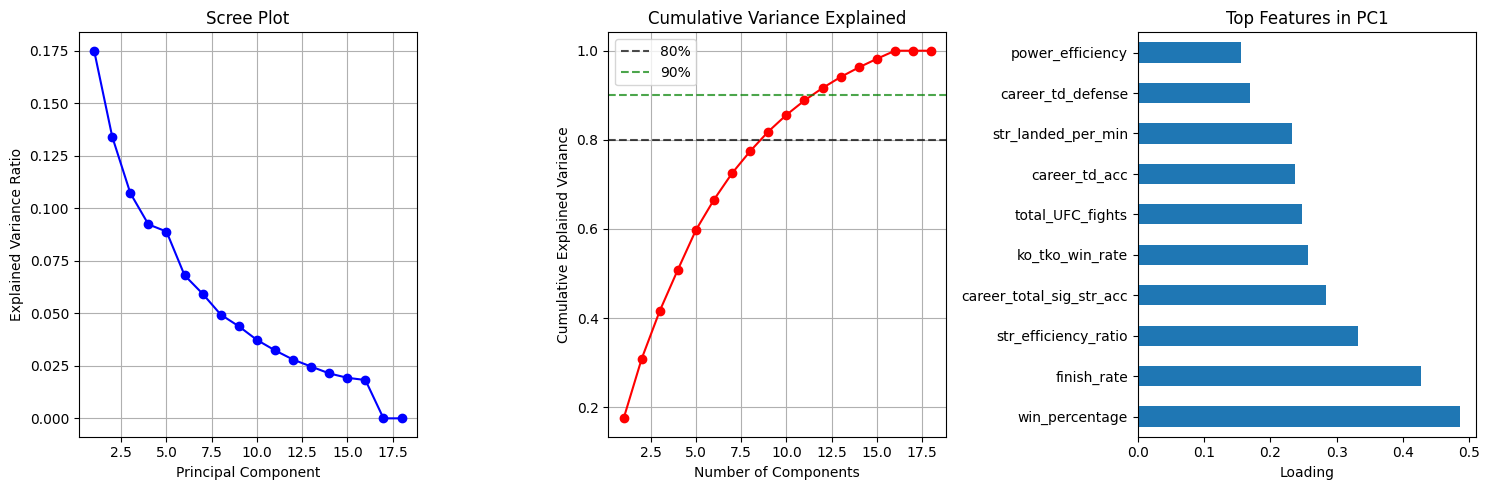

Components needed:
  80% variance: 9 components
  90% variance: 12 components
  Recommendation: Use 9 components to start

PCA Results:
  Original features: 18
  PCA components: 9
  Variance explained: 0.819


In [24]:
# Apply PCA to see how many components we need
pca_full = PCA()
pca_full.fit(scaled_features)

# Plot explained variance
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1), 
         pca_full.explained_variance_ratio_, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(True)

plt.subplot(1, 3, 2)
cumvar = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(range(1, len(cumvar) + 1), cumvar, 'ro-')
plt.axhline(y=0.8, color='k', linestyle='--', alpha=0.7, label='80%')
plt.axhline(y=0.9, color='g', linestyle='--', alpha=0.7, label='90%')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance Explained')
plt.legend()
plt.grid(True)

# Find number of components for 80% and 90% variance
n_80 = np.argmax(cumvar >= 0.8) + 1
n_90 = np.argmax(cumvar >= 0.9) + 1

plt.subplot(1, 3, 3)
# Show feature importance for first 2 components
components_df = pd.DataFrame(
    pca_full.components_[:2].T,
    columns=['PC1', 'PC2'],
    index=available_features
)
components_df['abs_PC1'] = abs(components_df['PC1'])
components_df.sort_values('abs_PC1', ascending=False).head(10)['PC1'].plot(kind='barh')
plt.title('Top Features in PC1')
plt.xlabel('Loading')

plt.tight_layout()
plt.show()

print(f"Components needed:")
print(f"  80% variance: {n_80} components")
print(f"  90% variance: {n_90} components")
print(f"  Recommendation: Use {n_80} components to start")

# Apply PCA with recommended number of components
n_components = n_80
pca = PCA(n_components=n_components)
pca_features = pca.fit_transform(scaled_features)

print(f"\nPCA Results:")
print(f"  Original features: {scaled_features.shape[1]}")
print(f"  PCA components: {pca_features.shape[1]}")
print(f"  Variance explained: {pca.explained_variance_ratio_.sum():.3f}")

# Exploratory Graphs

In [ ]:
# Basic data exploration
print("Dataset Shape:", fighters.shape)
print("\nMissing Values:")
missing_pct = (fighters.isnull().sum() / len(fighters) * 100).sort_values(ascending=False)
print(missing_pct[missing_pct > 0].head(10))

print("\nWeight Class Distribution:")
print(fighters['weight_class'].value_counts())

print("\nBasic Stats:")
numeric_cols = fighters.select_dtypes(include=[np.number]).columns
print(f"Numeric columns: {len(numeric_cols)}")
print(f"Average fights per fighter: {fighters['total_UFC_fights'].mean():.1f}")
print(f"Average win rate: {fighters['win_percentage'].mean():.1f}%")

In [5]:
for col in fighter_df.columns: print(col)

id
total_UFC_fights
UFC_wins
UFC_losses
last_fight
total_fight_time_sec
total_rounds_fought
kd
sig_str_landed
sig_str_atmpted
total_str_landed
total_str_atmpted
td_landed
td_atmpted
ctrl
sub_att
head_landed
head_atmpted
body_landed
body_atmpted
leg_landed
leg_atmpted
dist_landed
dist_atmpted
clinch_landed
clinch_atmpted
ground_landed
ground_atmpted
sig_str_absorbed
total_str_absorbed
takedowns_allowed
time_controlled
knockdowns_absorbed
takedowns_defended
subs_defended
head_absorbed
body_absorbed
leg_absorbed
dist_absorbed
clinch_absorbed
ground_absorbed
ctrl_differential
str_differential
opp_sig_str_landed
opp_takedowns_landed
name
division
wins_by_ko_tko
losses_by_ko_tko
wins_by_submission
losses_by_submission
wins_by_decision
losses_by_decision
wins_by_other
losses_by_other
career_total_sig_str_acc
career_total_str_acc
career_td_acc
career_head_acc
career_body_acc
career_leg_acc
career_dist_acc
career_clinch_acc
career_ground_acc
str_landed_per_min
td_per_min
td_att_per_min
kd_per_m

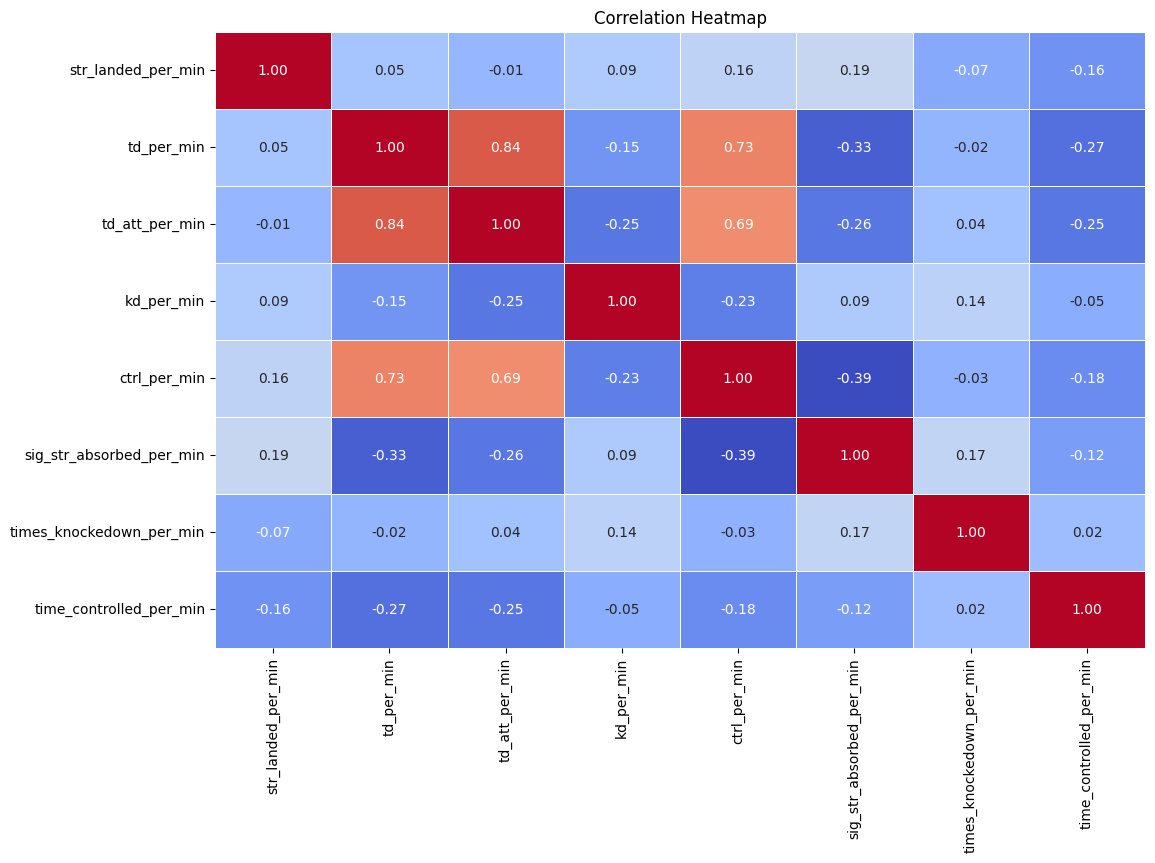

In [6]:
# Exploratory Graphs
corr_columns = ['str_landed_per_min','td_per_min','td_att_per_min','kd_per_min','ctrl_per_min',
                'sig_str_absorbed_per_min','times_knockedown_per_min','time_controlled_per_min']

# Compute correlation matrix
corr_matrix = fighter_df[corr_columns].corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar = False)

plt.title('Correlation Heatmap')
plt.show()

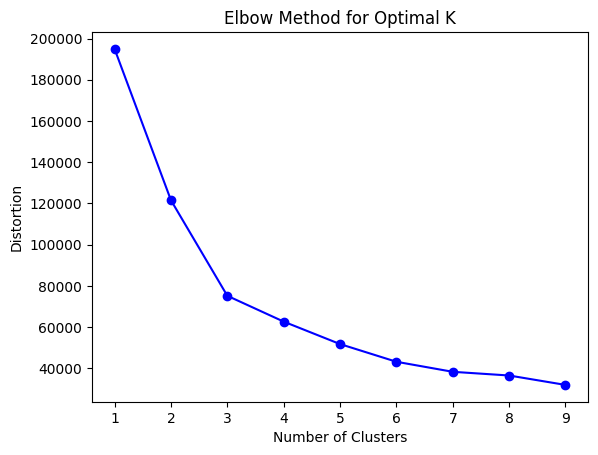

In [7]:
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(fighter_df[corr_columns])
    distortions.append(kmeans.inertia_)

plt.plot(K, distortions, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal K')
plt.show()